# Model Building & Evaluation

**Objective**:  
Train and evaluate fraud detection models using proper preprocessing, imbalance handling, and metrics.

This notebook uses modular functions from `src/model_preprocessing.py`.
___
## 1. Setup & Load Processed Data

In [1]:
import sys
import os
# Add project root (one directory above "notebooks")
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
from src.model_preprocessing import prepare_data_for_modeling

In [3]:
# Load engineered datasets
fraud_df = pd.read_csv('../data/processed/fraud_data_engineered.csv')
cc_df = pd.read_csv('../data/processed/creditcard_processed.csv')
print("Fraud_Data loaded:", fraud_df.shape)
print("CreditCard loaded:", cc_df.shape)

Fraud_Data loaded: (151112, 13)
CreditCard loaded: (283726, 31)



## 2. Data Transformation & Handling Class Imbalance

a. `fraud_data_engineered.csv` 


- **justification** : For the E-commerce dataset (9.4% fraud), I chose SMOTE over undersampling. Undersampling would have required discarding over 80% of the legitimate transaction data, significantly reducing the model's ability to learn normal patterns. Since the minority class was sufficiently represented (not extremely rare), SMOTE allowed me to balance the classes while retaining all valuable information from the majority class.

In [4]:
fraud_df# Separate features and target
X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']

In [5]:
# it's good to remove redundant features for: Cleaner interpretation (SHAP), Faster training, Professionalism
cols_to_drop = ['user_total_spent', 'user_avg_purchase']  # Redundant
X_fraud = X_fraud.drop(columns=cols_to_drop)

In [6]:
# Split and balance — SMOTE is good here (~9.4% fraud)
X_train_bal_f, y_train_bal_f, X_test_f, y_test_f, preprocessor_f = prepare_data_for_modeling(
    X_fraud, y_fraud,
    dataset_name="Fraud_Data",
    imbalance_technique="smote",  
    test_size=0.2,
    random_state=42
)


=== Preparing Fraud_Data for Modeling ===
Applying SMOTE...
✅ Ready for modeling! Train Shape: (219136, 195)


a. `creditcard_processed.csv` 


- **justification** : The class imbalance in the Credit Card dataset is extreme (0.17% fraud vs 99.83% legitimate). While 1:1 Undersampling was considered, it was rejected because it would require discarding over 99% of the legitimate transactions (reducing ~227,000 rows to just ~756). This massive information loss would prevent the model from learning complex "normal" behaviors, leading to high False Positive rates.
Instead, I opted for `SMOTETomek`. This hybrid technique offers the best of both worlds: it uses SMOTE to upsample the minority class (allowing us to retain the rich information in the majority class) and subsequently applies Tomek Links to remove noisy/overlapping data points at the decision boundary. This creates a clearer separation between fraud and legitimate transactions without the noise usually introduced by pure SMOTE.

In [7]:
X_cc = cc_df.drop('Class', axis=1)
y_cc = cc_df['Class']
X_train_bal_c, y_train_bal_c, X_test_c, y_test_c, preprocessor_c = prepare_data_for_modeling(
    X_cc, y_cc,
    dataset_name="CreditCard",
    imbalance_technique="smotetomek",  # or "smotetomek"
    test_size=0.2
)


=== Preparing CreditCard for Modeling ===
Applying SMOTETOMEK...
✅ Ready for modeling! Train Shape: (453204, 30)



## 3. Model Building and Training

**Baseline Model**


=== Fraud_Data - Logistic Regression Evaluation Results ===
AUC-PR: 0.3926

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     27393
           1       0.17      0.70      0.28      2830

    accuracy                           0.66     30223
   macro avg       0.56      0.68      0.53     30223
weighted avg       0.88      0.66      0.73     30223


Confusion Matrix:
[[17964  9429]
 [  854  1976]]


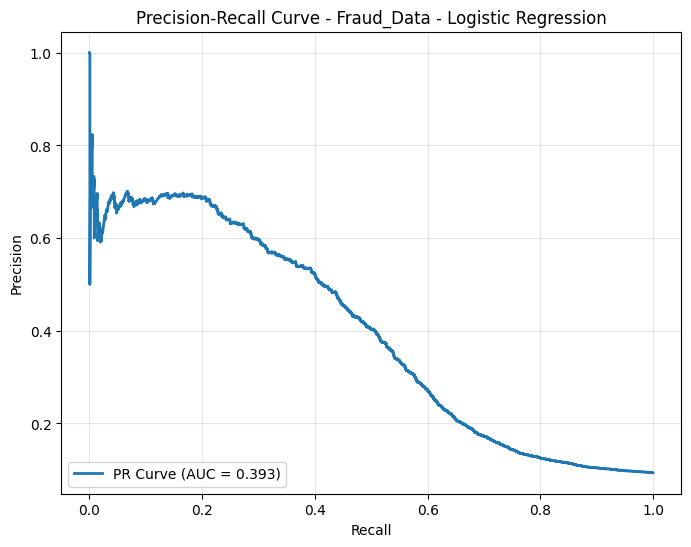


=== CreditCard - Logistic Regression Evaluation Results ===
AUC-PR: 0.7129

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746


Confusion Matrix:
[[55169  1482]
 [   12    83]]


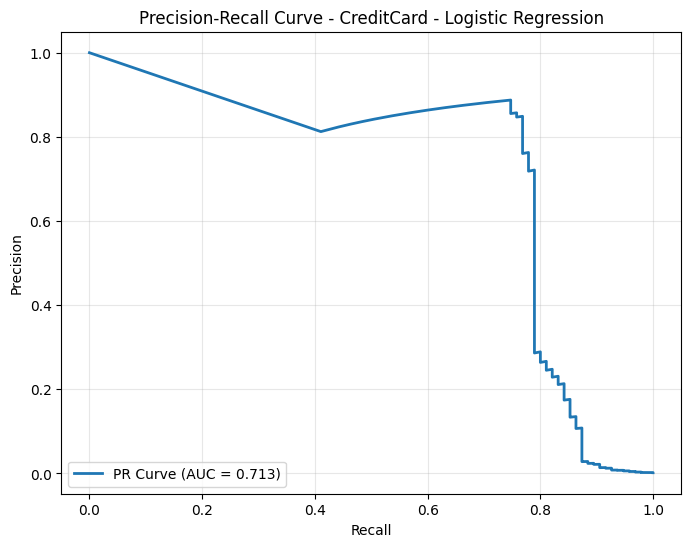

In [8]:
from sklearn.linear_model import LogisticRegression
from src.evaluation import evaluate_model

# Fraud_Data
lr_f = LogisticRegression(max_iter=1000, random_state=42)
lr_f.fit(X_train_bal_f, y_train_bal_f)
evaluate_model(lr_f, X_test_f, y_test_f, "Fraud_Data - Logistic Regression")

# CreditCard
lr_c = LogisticRegression(max_iter=1000, random_state=42)
lr_c.fit(X_train_bal_c, y_train_bal_c)
evaluate_model(lr_c, X_test_c, y_test_c, "CreditCard - Logistic Regression")

**Ensemble Model**
- Selected Model: XGBoost for both datasets
- Justification:
    - Significantly higher AUC-PR on both datasets
    - Superior precision-recall trade-off (especially high precision on Fraud_Data, balanced on CreditCard)
    - Captures non-linear patterns that Logistic Regression misses
    - Although less inherently interpretable, full explainability will be provided via SHAP in Task 3
    - Efficient and suitable for real-time fraud detection

Best params (Fraud_Data): {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

=== Fraud_Data - XGBoost Evaluation Results ===
AUC-PR: 0.6070

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.96      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223


Confusion Matrix:
[[27331    62]
 [ 1344  1486]]


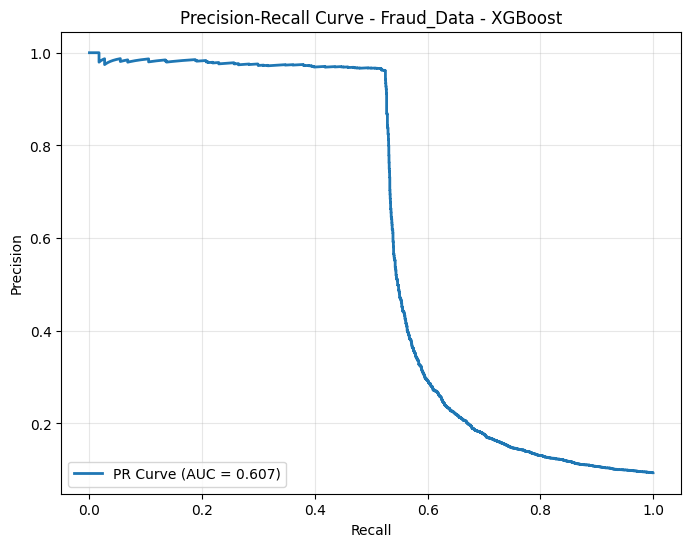

Best params (CreditCard): {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

=== CreditCard - XGBoost Evaluation Results ===
AUC-PR: 0.8137

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.76      0.82      0.79        95

    accuracy                           1.00     56746
   macro avg       0.88      0.91      0.90     56746
weighted avg       1.00      1.00      1.00     56746


Confusion Matrix:
[[56627    24]
 [   17    78]]


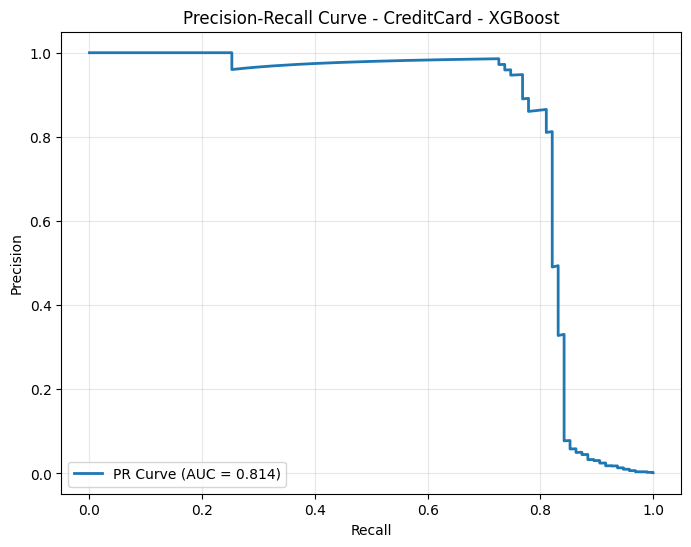

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Fraud_Data
xgb_f = XGBClassifier(
    random_state=42,
    eval_metric='aucpr',
    scale_pos_weight=1  # Already balanced, so no need
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1]
}

grid_f = GridSearchCV(xgb_f, param_grid, cv=5, scoring='average_precision', n_jobs=-1)
grid_f.fit(X_train_bal_f, y_train_bal_f)

print("Best params (Fraud_Data):", grid_f.best_params_)
evaluate_model(grid_f.best_estimator_, X_test_f, y_test_f, "Fraud_Data - XGBoost")

# CreditCard (same)
grid_c = GridSearchCV(xgb_f, param_grid, cv=5, scoring='average_precision', n_jobs=-1)
grid_c.fit(X_train_bal_c, y_train_bal_c)

print("Best params (CreditCard):", grid_c.best_params_)
evaluate_model(grid_c.best_estimator_, X_test_c, y_test_c, "CreditCard - XGBoost")

In [10]:
import joblib
joblib.dump(grid_f.best_estimator_, '../models/xgb_fraud_best.pkl')
joblib.dump(grid_c.best_estimator_, '../models/xgb_creditcard_best.pkl')
joblib.dump(preprocessor_f, '../models/preprocessor_fraud.pkl')
joblib.dump(preprocessor_c, '../models/preprocessor_creditcard.pkl')

['../models/preprocessor_creditcard.pkl']